# Introducing the ML Package  

In the previous chapter, we worked with the MLlib package in Spark that operated strictly on RDDs. In this chapter, we move to the ML part of Spark that operates strictly on DataFrames. Also, according to the Spark documentation, the primary machine learning API for Spark is now the DataFrame-based set of models contained in the spark.ml package.  

In this chapter, you will learn how to do the following:  
• Prepare transformers, estimators, and pipelines  
• Predict the chances of infant survival using models available in the
ML package  
• Evaluate the performance of the model  
• Perform parameter hyper-tuning  
• Use other machine-learning models available in the package

In [1]:
import os
from pyspark.sql import SparkSession
import pyspark.sql.functions as fn
import pyspark.sql.types as typ
import findspark
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import pyspark.ml.feature as ft

In [2]:
findspark.init("C:/Program Files/spark-3.5.4-bin-hadoop3")

In [3]:
os.environ["JAVA_HOME"] = "C:/Program Files/Java/jre1.8.0_431" 
os.environ["SPARK_HOME"] = "C:/Program Files/spark-3.5.4-bin-hadoop3" 
os.environ['HADOOP_HOME '] = 'C:/Program Files/hadoop-3.4.0/bin'

In [4]:
# Create a SparkSession

spark = SparkSession.builder \
    .appName("Introducing the ML Package").getOrCreate()

sc = spark.sparkContext  # Accès au SparkContext à partir de SparkSession


## Overview of the package  

At the top level, the package exposes three main abstract classes: a Transformer, an Estimator, and a Pipeline. We will shortly explain each with some short examples. We will provide more concrete examples of some of the models in the last section of this chapter.  


### Transformer  
The Transformer class, like the name suggests, transforms your data by (normally)
appending a new column to your DataFrame.  

At the high level, when deriving from the Transformer abstract class, each and
every new Transformer needs to implement a .transform(...) method. The
method, as a first and normally the only obligatory parameter, requires passing
a DataFrame to be transformed. This, of course, varies method-by-method in the
ML package: other popular parameters are inputCol and outputCol; these,
however, frequently default to some predefined values, such as, for example,
'features' for the inputCol parameter.  

There are many Transformers offered in the spark.ml.feature and we will briefly
describe them here (before we use some of them later in this chapter):  
* Binarizer: Given a threshold, the method takes a continuous variable and
transforms it into a binary one.  
* Bucketizer: Similar to the Binarizer, this method takes a list of thresholds
(the splits parameter) and transforms a continuous variable into a
multinomial one.  
* ChiSqSelector: For the categorical target variables (think classification
models), this feature allows you to select a predefined number of features
(parameterized by the numTopFeatures parameter) that explain the variance in
the target the best. The selection is done, as the name of the method suggests,
using a Chi-Square test. It is one of the two-step methods: first, you need
to .fit(...) your data (so the method can calculate the Chi-square tests).
Calling the .fit(...) method (you pass your DataFrame as a parameter)
returns a ChiSqSelectorModel object that you can then use to transform
your DataFrame using the .transform(...) method.  
* CountVectorizer: This is useful for a tokenized text (such as
[['Learning', 'PySpark', 'with', 'us'],['us', 'us', 'us']]).
It is one of two-step methods: first, you need to .fit(...), that is, learn
the patterns from your dataset, before you can .transform(...) with the
CountVectorizerModel returned by the .fit(...) method. The output
from this transformer, for the tokenized text presented previously, would
look similar to this: [(4, [0, 1, 2, 3], [1.0, 1.0, 1.0, 1.0]),(4,
[3], [3.0])].  
* DCT: The Discrete Cosine Transform takes a vector of real values and returns
a vector of the same length, but with the sum of cosine functions oscillating
at different frequencies. Such transformations are useful to extract some
underlying frequencies in your data or in data compression.  
* ElementwiseProduct: A method that returns a vector with elements that
are products of the vector passed to the method, and a vector passed as the
scalingVec parameter. For example, if you had a [10.0, 3.0, 15.0]
vector and your scalingVec was [0.99, 3.30, 0.66], then the vector
you would get would look as follows: [9.9, 9.9, 9.9].  
* HashingTF: A hashing trick transformer that takes a list of tokenized text
and returns a vector (of predefined length) with counts  
* IDF: This method computes an Inverse Document Frequency for a list of
documents. Note that the documents need to already be represented as a
vector (for example, using either the HashingTF or CountVectorizer).  
* IndexToString: A complement to the StringIndexer method. It uses the
encoding from the StringIndexerModel object to reverse the string index to
original values. As an aside, please note that this sometimes does not work
and you need to specify the values from the StringIndexer.  
* MaxAbsScaler: Rescales the data to be within the [-1.0, 1.0] range
(thus, it does not shift the center of the data).  
* MinMaxScaler: This is similar to the MaxAbsScaler with the difference that it
scales the data to be in the [0.0, 1.0] range.  
* NGram: This method takes a list of tokenized text and returns n-grams: pairs,
triples, or n-mores of subsequent words. For example, if you had a ['good',
'morning', 'Robin', 'Williams'] vector you would get the following
output: ['good morning', 'morning Robin', 'Robin Williams'].  
* Normalizer: This method scales the data to be of unit norm using the
p-norm value (by default, it is L2).  
* OneHotEncoder: This method encodes a categorical column to a column
of binary vectors.  
* PCA: Performs the data reduction using principal component analysis  
* PolynomialExpansion: Performs a polynomial expansion of a vector. For
example, if you had a vector symbolically written as [x, y, z], the method
would produce the following expansion: [x, x*x, y, x*y, y*y, z, x*z,
y*z, z*z].  
* QuantileDiscretizer: Similar to the Bucketizer method, but instead of
passing the splits parameter, you pass the numBuckets one. The method then
decides, by calculating approximate quantiles over your data, what the splits
should be.  
* RegexTokenizer: This is a string tokenizer using regular expressions.  
* RFormula: For those of you who are avid R users, you can pass a formula
such as vec ~ alpha * 3 + beta (assuming your DataFrame has the alpha
and beta columns) and it will produce the vec column given the expression.  
* SQLTransformer: Similar to the previous, but instead of R-like formulas,
you can use SQL syntax. [The FROM statement should be selecting from __THIS__, indicating
you are accessing the DataFrame. For example: SELECT alpha * 3 +
beta AS vec FROM __THIS__.]  
* StandardScaler: Standardizes the column to have a 0 mean and standard
deviation equal to 1.  
* StopWordsRemover: Removes stop words (such as 'the' or 'a') from a
tokenized text.  
* StringIndexer: Given a list of all the words in a column, this will produce
a vector of indices  
* Tokenizer: This is the default tokenizer that converts the string to lower case
and then splits on space(s).  
* VectorAssembler: This is a highly useful transformer that collates multiple
numeric (vectors included) columns into a single column with a vector
representation.


In [ ]:
df = spark.createDataFrame(
[(12, 10, 3), (1, 4, 2)],
['a', 'b', 'c'])

ft.VectorAssembler(inputCols=['a', 'b', 'c'],
outputCol='features')\
.transform(df) \
.select('features')\
.collect()

* VectorIndexer: This is a method for indexing categorical columns into a
vector of indices. It works in a column-by-column fashion, selecting distinct
values from the column, sorting and returning an index of the value from
the map instead of the original value.  
* VectorSlicer: Works on a feature vector, either dense or sparse: given a list
of indices, it extracts the values from the feature vector.  
* Word2Vec: This method takes a sentence (string) as an input and transforms
it into a map of {string, vector} format, a representation that is useful in
natural language processing.  


### Estimators  
Estimators can be thought of as statistical models that need to be estimated to make
predictions or classify your observations.  

If deriving from the abstract Estimator class, the new model has to implement the
.fit(...) method that fits the model given the data found in a DataFrame and
some default or user-specified parameters.  




### Classification  

The ML package provides a data scientist with seven classification models to
choose from. These range from the simplest ones (such as logistic regression) to
more sophisticated ones. We will provide short descriptions of each of them in the
following section:  
* LogisticRegression: The benchmark model for classification. The logistic
regression uses a logit function to calculate the probability of an observation
belonging to a particular class. At the time of writing, the PySpark ML
supports only binary classification problems.  

* DecisionTreeClassifier: A classifier that builds a decision tree to predict a
class for an observation. Specifying the maxDepth parameter limits the depth
the tree grows, the minInstancePerNode determines the minimum number
of observations in the tree node required to further split, the maxBins
parameter specifies the maximum number of bins the continuous variables
will be split into, and the impurity specifies the metric to measure and
calculate the information gain from the split.  

* GBTClassifier: A Gradient Boosted Trees model for classification. The
model belongs to the family of ensemble models: models that combine
multiple weak predictive models to form a strong one. At the moment,
the GBTClassifier model supports binary labels, and continuous and
categorical features.  

* RandomForestClassifier: This model produces multiple decision trees
(hence the name—forest) and uses the mode output of those decision trees to
classify observations. The RandomForestClassifier supports both binary
and multinomial labels.  

* NaiveBayes: Based on the Bayes' theorem, this model uses conditional
probability theory to classify observations. The NaiveBayes model in
PySpark ML supports both binary and multinomial labels.  

* MultilayerPerceptronClassifier: A classifier that mimics the nature of
a human brain. Deeply rooted in the Artificial Neural Networks theory, the
model is a black-box, that is, it is not easy to interpret the internal parameters
of the model. The model consists, at a minimum, of three, fully connected
layers (a parameter that needs to be specified when creating the model
object) of artificial neurons: the input layer (that needs to be equal to the
number of features in your dataset), a number of hidden layers (at least one),
and an output layer with the number of neurons equal to the number of
categories in your label. All the neurons in the input and hidden layers have
a sigmoid activation function, whereas the activation function of the neurons
in the output layer is softmax.  

* OneVsRest: A reduction of a multiclass classification to a binary one. For
example, in the case of a multinomial label, the model can train multiple
binary logistic regression models. For example, if label == 2, the model
will build a logistic regression where it will convert the label == 2 to 1
(all remaining label values would be set to 0) and then train a binary
model. All the models are then scored and the model with the highest
probability wins.  

 

### Regression  

There are seven models available for regression tasks in the PySpark ML package. As
with classification, these range from some basic ones (such as the obligatory linear
regression) to more complex ones:  
* AFTSurvivalRegression: Fits an Accelerated Failure Time regression
model. It is a parametric model that assumes that a marginal effect of one of
the features accelerates or decelerates a life expectancy (or process failure).
It is highly applicable for the processes with well-defined stages.  

* DecisionTreeRegressor: Similar to the model for classification with
an obvious distinction that the label is continuous instead of binary
(or multinomial).  

* GBTRegressor: As with the DecisionTreeRegressor, the difference is the
data type of the label.  

* GeneralizedLinearRegression: A family of linear models with differing
kernel functions (link functions). In contrast to the linear regression that
assumes normality of error terms, the GLM allows the label to have different
error term distributions: the GeneralizedLinearRegression model from
the PySpark ML package supports gaussian, binomial, gamma, and poisson
families of error distributions with a host of different link functions.  

* IsotonicRegression: A type of regression that fits a free-form, nondecreasing
line to your data. It is useful to fit the datasets with ordered and
increasing observations.  

* LinearRegression: The most simple of regression models, it assumes a
linear relationship between features and a continuous label, and normality
of error terms.  

* RandomForestRegressor: Similar to either DecisionTreeRegressor or
GBTRegressor, the RandomForestRegressor fits a continuous label instead
of a discrete one.

### Clustering  

Clustering is a family of unsupervised models that are used to find underlying
patterns in your data. The PySpark ML package provides the four most popular
models at the moment:  
* BisectingKMeans: A combination of the k-means clustering method and
hierarchical clustering. The algorithm begins with all observations in
a single cluster and iteratively splits the data into k clusters.  

* KMeans: This is the famous k-mean algorithm that separates data into
k clusters, iteratively searching for centroids that minimize the sum of
square distances between each observation and the centroid of the cluster
it belongs to.  

* GaussianMixture: This method uses k Gaussian distributions with unknown
parameters to dissect the dataset. Using the Expectation-Maximization
algorithm, the parameters for the Gaussians are found by maximizing the
log-likelihood function. [Beware that for datasets with many features this model might
perform poorly due to the curse of dimensionality and numerical
issues with Gaussian distributions.]    

* LDA: This model is used for topic modeling in natural language processing
applications.

### Pipeline  

A Pipeline in PySpark ML is a concept of an end-to-end transformation-estimation
process (with distinct stages) that ingests some raw data (in a DataFrame form),
performs the necessary data carpentry (transformations), and finally estimates a
statistical model (estimator).  [A Pipeline can be purely transformative, that is, consisting of
Transformers only.]

A Pipeline can be thought of as a chain of multiple discrete stages. When a
.fit(...) method is executed on a Pipeline object, all the stages are executed in
the order they were specified in the stages parameter; the stages parameter is a
list of Transformer and Estimator objects. The .fit(...) method of the Pipeline
object executes the .transform(...) method for the Transformers and the
.fit(...) method for the Estimators.  
Normally, the output of a preceding stage becomes the input for the following
stage: when deriving from either the Transformer or Estimator abstract classes,
one needs to implement the .getOutputCol() method that returns the value of the
outputCol parameter specified when creating an object.  



## Predicting the chances of infant survival with ML  

In this section, we will, once again, attempt to predict the chances of the survival of
an infant.

* **Loading the data**  

First, we load the data with the help of the following code:

In [6]:
import pyspark.sql.types as typ  

labels = [
    ('INFANT_ALIVE_AT_REPORT', typ.IntegerType()),
    ('BIRTH_PLACE', typ.StringType()),
    ('MOTHER_AGE_YEARS', typ.IntegerType()),
    ('FATHER_COMBINED_AGE', typ.IntegerType()),
    ('CIG_BEFORE', typ.IntegerType()),
    ('CIG_1_TRI', typ.IntegerType()),
    ('CIG_2_TRI', typ.IntegerType()),
    ('CIG_3_TRI', typ.IntegerType()),
    ('MOTHER_HEIGHT_IN', typ.IntegerType()),
    ('MOTHER_PRE_WEIGHT', typ.IntegerType()),
    ('MOTHER_DELIVERY_WEIGHT', typ.IntegerType()),
    ('MOTHER_WEIGHT_GAIN', typ.IntegerType()),
    ('DIABETES_PRE', typ.IntegerType()),
    ('DIABETES_GEST', typ.IntegerType()),
    ('HYP_TENS_PRE', typ.IntegerType()),
    ('HYP_TENS_GEST', typ.IntegerType()),
    ('PREV_BIRTH_PRETERM', typ.IntegerType())
]

schema = typ.StructType([
    typ.StructField(e[0], e[1], False) for e in labels
])  


births = spark.read.csv('datasets/births_transformed.csv.gz', 
                        header=True, 
                        schema=schema)



We specify the schema of the DataFrame; our severely limited dataset now only
has 17 columns.

### Creating transformers  

Before we can use the dataset to estimate a model, we need to do some
transformations. Since statistical models can only operate on numeric data,
we will have to encode the BIRTH_PLACE variable.  

Before we do any of this, since we will use a number of different feature
transformations later in this chapter, let's import them all:

In [7]:
import pyspark.ml.feature as ft

To encode the BIRTH_PLACE column, we will use the OneHotEncoder method.
However, the method cannot accept StringType columns; it can only deal with
numeric types so first we will cast the column to an IntegerType:

In [8]:
births = births \
.withColumn('BIRTH_PLACE_INT', births['BIRTH_PLACE'] \
.cast(typ.IntegerType()))

Having done this, we can now create our first Transformer:

In [9]:
encoder = ft.OneHotEncoder(
inputCol='BIRTH_PLACE_INT',
outputCol='BIRTH_PLACE_VEC')

Let's now create a single column with all the features collated together. We will use
the VectorAssembler method:

In [10]:
featuresCreator = ft.VectorAssembler(
inputCols=[col[0] for col in labels[2:]] + [encoder.getOutputCol()], outputCol='features'
)

The inputCols parameter passed to the VectorAssembler object is a list of all the
columns to be combined together to form the outputCol—the 'features'. Note
that we use the output of the encoder object (by calling the .getOutputCol()
method), so we do not have to remember to change this parameter's value should
we change the name of the output column in the encoder object at any point.  

It's now time to create our first estimator.

### Creating an estimator  

In this example, we will (once again) use the logistic regression model. However,
later in the chapter, we will showcase some more complex models from the
.classification set of PySpark ML models, so we load the whole section:

In [11]:
import pyspark.ml.classification as cl

Once loaded, let's create the model by using the following code:

In [12]:
logistic = cl.LogisticRegression(
maxIter=10,
regParam=0.01,
labelCol='INFANT_ALIVE_AT_REPORT')

We would not have to specify the labelCol parameter if our target column had
the name 'label'. Also, if the output of our featuresCreator was not called
'features', we would have to specify the featuresCol by (most conveniently)
calling the getOutputCol() method on the featuresCreator object.

### Creating a pipeline  

All that is left now is to create a Pipeline and fit the model. First, let's load the
Pipeline from the ML package:  

In [13]:
from pyspark.ml import Pipeline

Creating a Pipeline is really easy. Here's how our pipeline should look like
conceptually:  
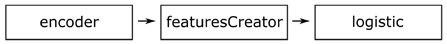

Converting this structure into a Pipeline is a walk in the park:

In [14]:
pipeline = Pipeline(
    stages=[encoder,
            featuresCreator,
            logistic])

That's it! Our pipeline is now created so we can (finally!) estimate the model.

### Fitting the model  
Before you fit the model, we need to split our dataset into training and testing
datasets. Conveniently, the DataFrame API has the .randomSplit(...) method:  



In [15]:
births_train, births_test = births.randomSplit([0.7, 0.3], seed=666)

The first parameter is a list of dataset proportions that should end up in, respectively,
births_train and births_test subsets. The seed parameter provides a seed to the
randomizer. 
You can also split the dataset into more than two subsets as long as the
elements of the list sum up to 1, and you unpack the output into as many
subsets.  

For example, we could split the births dataset into three subsets like this:  
***
train, test, val = births.randomSplit([0.7, 0.2, 0.1], seed=666)  
The preceding code would put a random 70% of the births dataset into the train object, 20% would go to the test, and the val DataFrame would hold the remaining 10%.  
***  

Now it is about time to finally run our pipeline and estimate our model:

In [16]:
model = pipeline.fit(births_train)
test_model = model.transform(births_test)

The .fit(...) method of the pipeline object takes our training dataset as an
input. Under the hood, the births_train dataset is passed first to the encoder
object. The DataFrame that is created at the encoder stage then gets passed to the
featuresCreator that creates the 'features' column. Finally, the output from this
stage is passed to the logistic object that estimates the final model.

The .fit(...) method of the pipeline object takes our training dataset as an
input. Under the hood, the births_train dataset is passed first to the encoder
object. The DataFrame that is created at the encoder stage then gets passed to the
featuresCreator that creates the 'features' column. Finally, the output from this
stage is passed to the logistic object that estimates the final model.

In [ ]:
test_model.take(1)

As you can see, we get all the columns from the Transfomers and Estimators. The
logistic regression model outputs several columns: the rawPrediction is the value
of the linear combination of features and the β coefficients, the probability is the
calculated probability for each of the classes, and finally, the prediction is our final
class assignment.

### Evaluating the performance of the model  

Obviously, we would like to now test how well our model did. PySpark exposes a
number of evaluation methods for classification and regression in the .evaluation
section of the package:

In [18]:
import pyspark.ml.evaluation as ev

We will use the BinaryClassficationEvaluator to test how well our model
performed:

In [19]:
evaluator = ev.BinaryClassificationEvaluator(
    rawPredictionCol='probability',
    labelCol='INFANT_ALIVE_AT_REPORT')

The rawPredictionCol can either be the rawPrediction column produced by the
estimator or the probability.

Let's see how well our model performed:

In [ ]:
print(evaluator.evaluate(test_model, {evaluator.metricName: 'areaUnderROC'}))
print(evaluator.evaluate(test_model, {evaluator.metricName: 'areaUnderPR'}))

The area under the ROC of 74% and area under PR of 71% shows a well-defined
model, but nothing out of extraordinary; if we had other features, we could drive
this up, but this is not the purpose of this chapter

### Saving the model  
PySpark allows you to save the Pipeline definition for later use. It not only saves
the pipeline structure, but also all the definitions of all the Transformers and
Estimators:

In [21]:
#ipelinePath = './infant_oneHotEncoder_Logistic_Pipeline'
#pipeline.write().overwrite().save(pipelinePath)

So, you can load it up later and use it straight away to .fit(...) and predict:

In [22]:
# loadedPipeline = Pipeline.load(pipelinePath)
# loadedPipeline.fit(births_train).transform(births_test).take(1)

If you, however, want to save the estimated model, you can also do that; instead of
saving the Pipeline, you need to save the PipelineModel.  
[Note, that not only the PipelineModel can be saved: virtually all
the models that are returned by calling the .fit(...) method on an
Estimator or Transformer can be saved and loaded back to be reused.]

To save your model, see the following the example:

In [23]:
from pyspark.ml import PipelineModel

In [29]:
# modelPath = 'C:/Users/balde/OneDrive/Bureau/TO DO/DE/Learning_PySpark/model'
# model.write().overwrite().save(modelPath)

# loadedPipelineModel = PipelineModel.load(modelPath)
# test_reloadedModel = loadedPipelineModel.transform(births_test)

The preceding script uses the .load(...) method, a class method of the
PipelineModel class, to reload the estimated model. You can compare the result
of test_reloadedModel.take(1) with the output of test_model.take(1) we
presented earlier.

### Parameter hyper-tuning  

Rarely, our first model would be the best we can do. By simply looking at our
metrics and accepting the model because it passed our pre-conceived performance
thresholds is hardly a scientific method for finding the best model.  

A concept of parameter hyper-tuning is to find the best parameters of the model: for
example, the maximum number of iterations needed to properly estimate the logistic
regression model or maximum depth of a decision tree.  

In this section, we will explore two concepts that allow us to find the best parameters
for our models: grid search and train-validation splitting.

#### Grid search  

Grid search is an exhaustive algorithm that loops through the list of defined
parameter values, estimates separate models, and chooses the best one given
some evaluation metric.  

A note of caution should be stated here: if you define too many parameters you
want to optimize over, or too many values of these parameters, it might take a lot of
time to select the best model as the number of models to estimate would grow very
quickly as the number of parameters and parameter values grow.  

For example, if you want to fine-tune two parameters with two parameter values,
you would have to fit four models. Adding one more parameter with two values
would require estimating eight models, whereas adding one more additional value
to our two parameters (bringing it to three values for each) would require estimating
nine models. As you can see, this can quickly get out of hand if you are not careful.  

After this cautionary tale, let's get to fine-tuning our parameters space. First, we load
the .tuning part of the package:

In [30]:
import pyspark.ml.tuning as tune

Next, let's specify our model and the list of parameters we want to loop through:

In [31]:
logistic = cl.LogisticRegression(labelCol='INFANT_ALIVE_AT_REPORT')

grid = tune.ParamGridBuilder(
    ).addGrid(logistic.maxIter, 
              [2, 10, 50]
    ).addGrid(logistic.regParam, 
                [0.01, 0.05, 0.3]
    ).build()

First, we specify the model we want to optimize the parameters of. Next, we decide
which parameters we will be optimizing, and what values for those parameters to
test. We use the ParamGridBuilder() object from the .tuning subpackage, and
keep adding the parameters to the grid with the .addGrid(...) method: the first
parameter is the parameter object of the model we want to optimize (in our case,
these are logistic.maxIter and logistic.regParam), and the second parameter
is a list of values we want to loop through. Calling the .build() method on the
.ParamGridBuilder builds the grid.

Next, we need some way of comparing the models:

In [32]:
evaluator = ev.BinaryClassificationEvaluator(rawPredictionCol='probability', labelCol='INFANT_ALIVE_AT_REPORT')

So, once again, we'll use the BinaryClassificationEvaluator. It is time now to
create the logic that will do the validation work for us:

In [33]:
cv = tune.CrossValidator(estimator=logistic, estimatorParamMaps=grid, evaluator=evaluator)

The CrossValidator needs the estimator, the estimatorParamMaps, and the
evaluator to do its job. The model loops through the grid of values, estimates
the models, and compares their performance using the evaluator.

We cannot use the data straight away (as the births_train and births_test still
have the BIRTHS_PLACE column not encoded) so we create a purely transforming
Pipeline:

In [34]:
pipeline = Pipeline(stages=[encoder ,featuresCreator])
data_transformer = pipeline.fit(births_train)

Having done this, we are ready to find the optimal combination of parameters for
our model:

In [35]:
cvModel = cv.fit(data_transformer.transform(births_train))

The cvModel will return the best model estimated. We can now use it to see if it
performed better than our previous model:

In [ ]:
data_train = data_transformer.transform(births_test)

results = cvModel.transform(data_train)

print(evaluator.evaluate(results, {evaluator.metricName: 'areaUnderROC'}))
print(evaluator.evaluate(results, {evaluator.metricName: 'areaUnderPR'}))

What parameters has the best model? The answer is a little bit convoluted but here's how you can extract it.

In [ ]:
results = [
    (
        [
            {key.name: paramValue} 
            for key, paramValue 
            in zip(
                params.keys(), 
                params.values())
        ], metric
    ) 
    for params, metric 
    in zip(
        cvModel.getEstimatorParamMaps(), 
        cvModel.avgMetrics
    )
]

sorted(results, key=lambda el: el[1], reverse=True)[0]

#### Train-validation splitting  

The TrainValidationSplit model, to select the best model, performs a random
split of the input dataset (the training dataset) into two subsets: smaller training
and validation subsets. The split is only performed once.  

In this example, we will also use the ChiSqSelector to select only the top five
features, thus limiting the complexity of our model:

In [38]:
selector = ft.ChiSqSelector(
    numTopFeatures=5,
    featuresCol=featuresCreator.getOutputCol(),
    outputCol='selectedFeatures',
    labelCol='INFANT_ALIVE_AT_REPORT'
)

The numTopFeatures specifies the number of features to return. We will put
the selector after the featuresCreator, so we call the .getOutputCol() on the
featuresCreator.  



In [39]:
logistic = cl.LogisticRegression(
    labelCol='INFANT_ALIVE_AT_REPORT',
    featuresCol='selectedFeatures'
)

pipeline = Pipeline(stages=[encoder, featuresCreator, selector])
data_transformer = pipeline.fit(births_train)


The TrainValidationSplit object gets created in the same fashion as the
CrossValidator model:

In [40]:
tvs = tune.TrainValidationSplit(
    estimator=logistic,
    estimatorParamMaps=grid,
    evaluator=evaluator
)

As before, we fit our data to the model, and calculate the results:

In [ ]:
tvsModel = tvs.fit(data_transformer.transform(births_train))

data_train = data_transformer.transform(births_test)  

results = tvsModel.transform(data_train)  

print(evaluator.evaluate(results, {evaluator.metricName: 'areaUnderROC'}))
print(evaluator.evaluate(results, {evaluator.metricName: 'areaUnderPR'}))

Well, the model with less features certainly performed worse than the full model, but
the difference was not that great. Ultimately, it is a performance trade-off between a
more complex model and the less sophisticated one.

## Other features of PySpark ML in action  

At the beginning of this chapter, we described most of the features of the PySpark
ML library. In this section, we will provide examples of how to use some of the
Transformers and Estimators.

### Feature extraction  

We have used quite a few models from this submodule of PySpark. In this section,
we'll show you how to use the most useful ones (in our opinion).

#### NLP - related feature extractors  

As described earlier, the NGram model takes a list of tokenized text and produces
pairs (or n-grams) of words.  

In this example, we will take an excerpt from PySpark's documentation and present
how to clean up the text before passing it to the NGram model. Here's how our dataset
looks like

In [42]:
text_data = spark.createDataFrame([
    ['''Machine learning can be applied to a wide variety 
        of data types, such as vectors, text, images, and 
        structured data. This API adopts the DataFrame from 
        Spark SQL in order to support a variety of data types.'''],
    ['''DataFrame supports many basic and structured types; 
        see the Spark SQL datatype reference for a list of 
        supported types. In addition to the types listed in 
        the Spark SQL guide, DataFrame can use ML Vector types.'''],
    ['''A DataFrame can be created either implicitly or 
        explicitly from a regular RDD. See the code examples 
        below and the Spark SQL programming guide for examples.'''],
    ['''Columns in a DataFrame are named. The code examples 
        below use names such as "text," "features," and "label."''']
], ['input'])

Each row in our single-column DataFrame is just a bunch of text. First, we need
to tokenize this text. To do so we will use the RegexTokenizer instead of just the
Tokenizer as we can specify the pattern(s) we want the text to be broken at:

In [43]:
tokenizer = ft.RegexTokenizer(
    inputCol='input',
    outputCol='input_arr',
    pattern='\s+|[,.\"]')

The pattern here splits the text on any number of spaces, but also removes commas,
full stops, backslashes, and quotation marks.

The output of the tokenizer looks similar to this.

In [ ]:
tok = tokenizer.transform(text_data).select('input_arr') 

tok.take(1)

As you can see, the RegexTokenizer not only splits the sentences in to words, but
also normalizes the text so each word is in small-caps.

However, there is still plenty of junk in our text: words such as be, a, or to normally
provide us with nothing useful when analyzing a text. Thus, we will remove these
so called stopwords using nothing else other than the StopWordsRemover(...):

In [45]:
stopwords = ft.StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol='input_stop')

The output of the method looks as follows

In [ ]:
stopwords.transform(tok).select('input_stop').take(1)

Now we only have the useful words. So, let's build our NGram model and the
Pipeline:

In [47]:
ngram = ft.NGram(n=2, inputCol=stopwords.getOutputCol(), outputCol="nGrams")

pipeline = Pipeline(stages=[tokenizer, stopwords, ngram])

Now that we have the pipeline, we follow in a very similar fashion as before:

In [ ]:
data_ngram = pipeline.fit(text_data).transform(text_data)

data_ngram.select('nGrams').take(1)

That's it. We have got our n-grams and we can now use them in further NLP
processing.

#### Discretizing continuous variables  

Ever so often, we deal with a continuous feature that is highly non-linear and really
hard to fit in our model with only one coefficient.  

In such a situation, it might be hard to explain the relationship between such a
feature and the target with just one coefficient. Sometimes, it is useful to band the
values into discrete buckets.

First, let's create some fake data with the help of the following code:

In [49]:
import numpy as np
x = np.arange(0, 100)
x = x / 100.0 * np.pi * 4
y = x * np.sin(x / 1.764) + 20.1234 

Now, we can create a DataFrame by using the following code:

In [ ]:
schema = typ.StructType([typ.StructField('continuous_var',typ.DoubleType(),False)])

data = spark.createDataFrame([[float(e), ] for e in y], schema=schema)
data.show(1)

Next, we will use the QuantileDiscretizer model to split our continuous variable
into five buckets (the numBuckets parameter):

In [51]:
discretizer = ft.QuantileDiscretizer(numBuckets=5, inputCol='continuous_var', outputCol='discretized')

Let's see what we have got:

In [ ]:
data_discretized = discretizer.fit(data).transform(data)
data_discretized.show(2)

In [ ]:
data_discretized \
    .groupby('discretized')\
    .mean('continuous_var')\
    .sort('discretized')\
    .collect()

We can now treat this variable as categorical and use the OneHotEncoder to encode it
for future use.

#### Standardizing continuous variables  

Standardizing continuous variables helps not only in better understanding the
relationships between the features (as interpreting the coefficients becomes easier),
but it also aids computational efficiency and protects from running into some
numerical traps. Here's how you do it with PySpark ML.

First, we need to create a vector representation of our continuous variable (as it is
only a single float):

In [54]:
vectorizer = ft.VectorAssembler(inputCols=['continuous_var'], outputCol= 'continuous_vec')

Next, we build our normalizer and the pipeline. By setting the withMean and
withStd to True, the method will remove the mean and scale the variance to be
of unit length:

In [55]:
normalizer = ft.StandardScaler(inputCol=vectorizer.getOutputCol(), outputCol='normalized', withMean=True, withStd=True)

pipeline = Pipeline(stages=[vectorizer, normalizer])

data_standardized = pipeline.fit(data).transform(data)

In [ ]:
data_standardized.show(2)

### Classification  

So far we have only used the LogisticRegression model from PySpark ML. In this
section, we will use the RandomForestClassfier to, once again, model the chances
of survival for an infant.  

Before we can do that, though, we need to cast the label feature to DoubleType:

In [59]:
import pyspark.sql.functions as func

births = births.withColumn(
    'INFANT_ALIVE_AT_REPORT',
    func.col('INFANT_ALIVE_AT_REPORT').cast(typ.DoubleType())
)
births_train, births_test = births.randomSplit([0.7, 0.3], seed=666)

Now that we have the label converted to double, we are ready to build our model.
We progress in a similar fashion as before with the distinction that we will reuse the
encoder and featureCreator from earlier in the chapter. The numTrees parameter
specifies how many decision trees should be in our random forest, and the maxDepth
parameter limits the depth of the trees:

In [60]:
classifier = cl.RandomForestClassifier(numTrees=5, maxDepth=5, labelCol='INFANT_ALIVE_AT_REPORT')

pipeline = Pipeline(stages=[encoder, featuresCreator, classifier])

model = pipeline.fit(births_train)
test = model.transform(births_test)

Let's now see how the RandomForestClassifier model performs compared to the
LogisticRegression:

In [ ]:
evaluator = ev.BinaryClassificationEvaluator(labelCol='INFANT_ALIVE_AT_REPORT')

print(evaluator.evaluate(test, {evaluator.metricName: "areaUnderROC"}))
print(evaluator.evaluate(test, {evaluator.metricName: "areaUnderPR"}))

Well, as you can see, the results are better than the logistic regression model by
roughly 3 percentage points. Let's test how well would a model with one tree do:

In [ ]:
classifier = cl.DecisionTreeClassifier(maxDepth=5, labelCol='INFANT_ALIVE_AT_REPORT')

pipeline = Pipeline(stages=[encoder, featuresCreator, classifier])

model = pipeline.fit(births_train)
test = model.transform(births_test)

evaluator = ev.BinaryClassificationEvaluator(labelCol='INFANT_ALIVE_AT_REPORT')

print(evaluator.evaluate(test, {evaluator.metricName: "areaUnderROC"}))
print(evaluator.evaluate(test, {evaluator.metricName: "areaUnderPR"}))

Not bad at all! It actually performed better than the random forest model in terms of
the precision-recall relationship and only slightly worse in terms of the area under
the ROC. We just might have found a winner!

### Clustering  
Clustering is another big part of machine learning: quite often, in the real world,
we do not have the luxury of having the target feature, so we need to revert to an
unsupervised learning paradigm, where we try to uncover patterns in the data.  

#### Finding clusters in the births dataset  

In this example, we will use the k-means model to find similarities in the births data:

In [63]:
import pyspark.ml.clustering as clus

kmeans = clus.KMeans(k = 5, featuresCol='features')

pipeline = Pipeline(stages=[encoder, featuresCreator, kmeans])

model = pipeline.fit(births_train)

Having estimated the model, let's see if we can find some differences between
clusters:

In [ ]:
test = model.transform(births_test)

test.groupBy('prediction').agg({
        '*': 'count', 
        'MOTHER_HEIGHT_IN': 'avg'
    }).collect()

Well, the MOTHER_HEIGHT_IN is significantly different in cluster 1. Going through the
results (which we will not do here for obvious reasons) would most likely uncover
more differences and allow us to understand the data better.

#### Topic mining  

Clustering models are not limited to numeric data only. In the field of NLP, problems
such as topic extraction rely on clustering to detect documents with similar topics.
We will go through such an example.

First, let's create our dataset. The data is formed from randomly selected paragraphs
found on the Internet: three of them deal with topics of nature and national parks,
the remaining three cover technology.

In [65]:
text_data = spark.createDataFrame([
    ['''To make a computer do anything, you have to write a 
    computer program. To write a computer program, you have 
    to tell the computer, step by step, exactly what you want 
    it to do. The computer then "executes" the program, 
    following each step mechanically, to accomplish the end 
    goal. When you are telling the computer what to do, you 
    also get to choose how it's going to do it. That's where 
    computer algorithms come in. The algorithm is the basic 
    technique used to get the job done. Let's follow an 
    example to help get an understanding of the algorithm 
    concept.'''],
    ['''Laptop computers use batteries to run while not 
    connected to mains. When we overcharge or overheat 
    lithium ion batteries, the materials inside start to 
    break down and produce bubbles of oxygen, carbon dioxide, 
    and other gases. Pressure builds up, and the hot battery 
    swells from a rectangle into a pillow shape. Sometimes 
    the phone involved will operate afterwards. Other times 
    it will die. And occasionally—kapow! To see what's 
    happening inside the battery when it swells, the CLS team 
    used an x-ray technology called computed tomography.'''],
    ['''This technology describes a technique where touch 
    sensors can be placed around any side of a device 
    allowing for new input sources. The patent also notes 
    that physical buttons (such as the volume controls) could 
    be replaced by these embedded touch sensors. In essence 
    Apple could drop the current buttons and move towards 
    touch-enabled areas on the device for the existing UI. It 
    could also open up areas for new UI paradigms, such as 
    using the back of the smartphone for quick scrolling or 
    page turning.'''],
    ['''The National Park Service is a proud protector of 
    America’s lands. Preserving our land not only safeguards 
    the natural environment, but it also protects the 
    stories, cultures, and histories of our ancestors. As we 
    face the increasingly dire consequences of climate 
    change, it is imperative that we continue to expand 
    America’s protected lands under the oversight of the 
    National Park Service. Doing so combats climate change 
    and allows all American’s to visit, explore, and learn 
    from these treasured places for generations to come. It 
    is critical that President Obama acts swiftly to preserve 
    land that is at risk of external threats before the end 
    of his term as it has become blatantly clear that the 
    next administration will not hold the same value for our 
    environment over the next four years.'''],
    ['''The National Park Foundation, the official charitable 
    partner of the National Park Service, enriches America’s 
    national parks and programs through the support of 
    private citizens, park lovers, stewards of nature, 
    history enthusiasts, and wilderness adventurers. 
    Chartered by Congress in 1967, the Foundation grew out of 
    a legacy of park protection that began over a century 
    ago, when ordinary citizens took action to establish and 
    protect our national parks. Today, the National Park 
    Foundation carries on the tradition of early park 
    advocates, big thinkers, doers and dreamers—from John 
    Muir and Ansel Adams to President Theodore Roosevelt.'''],
    ['''Australia has over 500 national parks. Over 28 
    million hectares of land is designated as national 
    parkland, accounting for almost four per cent of 
    Australia's land areas. In addition, a further six per 
    cent of Australia is protected and includes state 
    forests, nature parks and conservation reserves.National 
    parks are usually large areas of land that are protected 
    because they have unspoilt landscapes and a diverse 
    number of native plants and animals. This means that 
    commercial activities such as farming are prohibited and 
    human activity is strictly monitored.''']
], ['documents'])

First, we will once again use the RegexTokenizer and the StopWordsRemover models:

In [66]:
tokenizer = ft.RegexTokenizer(
    inputCol='documents', 
    outputCol='input_arr', 
    pattern='\s+|[,.\"]')

stopwords = ft.StopWordsRemover(
    inputCol=tokenizer.getOutputCol(), 
    outputCol='input_stop')

Next in our pipeline is the CountVectorizer: a model that counts words in a
document and returns a vector of counts. The length of the vector is equal to the
total number of distinct words in all the documents, which can be seen in the
following snippet:

In [ ]:

stringIndexer = ft.CountVectorizer(
    inputCol=stopwords.getOutputCol(), 
    outputCol="input_indexed")

tokenized = stopwords.transform(tokenizer.transform(text_data))
    
stringIndexer.fit(tokenized).transform(tokenized).select('input_indexed').take(2)

As you can see, there are 257 distinct words in the text, and each document is now
represented by a count of each word occurrence.

It's now time to start predicting the topics. For that purpose we will use the LDA
model—the Latent Dirichlet Allocation model:

In [68]:
clustering = clus.LDA(k=2, optimizer='online', featuresCol=stringIndexer.getOutputCol())

The k parameter specifies how many topics we expect to see, the optimizer
parameter can be either 'online' or 'em' (the latter standing for the Expectation
Maximization algorithm).

Putting these puzzles together results in, so far, the longest of our pipelines:

In [69]:
pipeline = Pipeline(stages=[
        tokenizer, 
        stopwords,
        stringIndexer, 
        clustering]
)

Have we properly uncovered the topics? Well, let's see:

In [ ]:
topics = pipeline \
    .fit(text_data) \
    .transform(text_data)

topics.select('topicDistribution').collect()

Looks like our method discovered all the topics properly! Do not get used to seeing
such good results though: sadly, real world data is seldom that kind.

### Regression  

We could not finish a chapter on a machine learning library without building a
regression model.  

In this section, we will try to predict the MOTHER_WEIGHT_GAIN given some of the
features described here; these are contained in the features listed here:

In [71]:
features = ['MOTHER_AGE_YEARS','MOTHER_HEIGHT_IN',
            'MOTHER_PRE_WEIGHT','DIABETES_PRE',
            'DIABETES_GEST','HYP_TENS_PRE', 
            'HYP_TENS_GEST', 'PREV_BIRTH_PRETERM',
            'CIG_BEFORE','CIG_1_TRI', 'CIG_2_TRI', 
            'CIG_3_TRI'
        ]

First, since all the features are numeric, we will collate them together and use the
ChiSqSelector to select only the top six most important features:

In [72]:
featuresCreator = ft.VectorAssembler(
    inputCols=[col for col in features[1:]], 
    outputCol='features'
)

selector = ft.ChiSqSelector(
    numTopFeatures=6, 
    outputCol="selectedFeatures", 
    labelCol='MOTHER_WEIGHT_GAIN'
)

In order to predict the weight gain, we will use the gradient boosted trees regressor:

In [73]:
import pyspark.ml.regression as reg

regressor = reg.GBTRegressor(
    maxIter=15, 
    maxDepth=3,
    labelCol='MOTHER_WEIGHT_GAIN')

Finally, again, we put it all together into a Pipeline:

In [75]:
pipeline = Pipeline(stages=[
        featuresCreator, 
        selector,
        regressor])

weightGain = pipeline.fit(births_train)

Having created the weightGain model, let's see if it performs well on our
testing data:

In [ ]:
evaluator = ev.RegressionEvaluator(
    predictionCol="prediction", 
    labelCol='MOTHER_WEIGHT_GAIN')

print(evaluator.evaluate(
    weightGain.transform(births_test), 
    {evaluator.metricName: 'r2'}))

Sadly, the model is no better than a flip of a coin. It looks that without additional
independent features that are better correlated with the MOTHER_WEIGHT_GAIN label,
we will not be able to explain its variance sufficiently.

## Summary
In this chapter, we went into details of how to use PySpark ML: the official main
machine learning library for PySpark. We explained what the Transformer and
Estimator are, and showed their role in another concept introduced in the ML
library: the Pipeline. Subsequently, we also presented how to use some of the
methods to fine-tune the hyper parameters of models. Finally, we gave some
examples of how to use some of the feature extractors and models from the library.  

In the next chapter, we will delve into graph theory and GraphFrames that help in
tackling machine learning problems better represented as graphs.